In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from time import time
from torchvision import transforms

import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import base64
import glob
from PIL import Image

from sklearn.decomposition import PCA, KernelPCA, FastICA

from sklearn.datasets import fetch_lfw_people
from pytorch_model_summary import summary
import logging

from VAE_big import VariationalAutoencoder

In [2]:
logger = logging.getLogger()
old_level = logger.level

# Utility Functions and Data

In [3]:
def plot_image_samples(X, transform =None):
    # Transforming data in range [0, 1]
    X = X if transform is None else transform(X)

    logger.setLevel(100)
    plt.figure(figsize=(18, 6))
    for idx, x in enumerate(X[:30]):
        plt.subplot(3, 10, idx+1)
        plt.imshow(x.transpose(0, 2).transpose(1, 0))
        plt.axis("off")
    plt.show()

In [4]:
# Set Device

device = 'cpu'

IMAGE_SHAPE = (3, 128, 128)
LATENT_DIMS = 64
SH = IMAGE_SHAPE[1] // 16

# Load VAE

In [5]:
# Instantiate Model

model = VariationalAutoencoder(latents=LATENT_DIMS).to(device)
print(summary(model, torch.zeros((1, *IMAGE_SHAPE)).to(device), show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
     EncoderConv-1     [1, 3, 128, 128]         675,446         675,446
     DecoderConv-2              [1, 64]         379,915         379,915
Total params: 1,055,361
Trainable params: 1,055,361
Non-trainable params: 0
------------------------------------------------------------------------


In [6]:
# Load Trained State
model.load_state_dict(torch.load("bestModel_ConvVae.pt"))

<All keys matched successfully>

# Load Dataset with Attributes

In [7]:
DATASET_PATH ="./data/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "./data/lfw_attributes.txt"

import glob, os
import pandas as pd

dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

def fetch_dataset(dx=80,dy=80, dimx=128,dimy=128):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

data, attrs = fetch_dataset()

In [9]:
print(data.shape)

smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = torch.tensor(data[smile_ids])
smile_data = torch.transpose(smile_data, 1, 3).transpose(2, 3)

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = torch.tensor(data[no_smile_ids])
no_smile_data = no_smile_data.transpose(1, 3).transpose(2, 3)

del(data)

(13143, 128, 128, 3)


[ 9745 10176  7740  9337 11192  8098 10458  8251  7309  9756  3410  2497
  7891  7266  6173 12498  2788  8383 10228  6882  4713  4909  1921 12525
 10934]
[11571  1234  7506  5458  7065 11912  1654   471  8410  8596 12688  1432
 10097 10506  9114  6321  3798  8092  2390  6019  2529 12298  9201  4392
  2000]


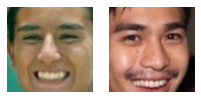

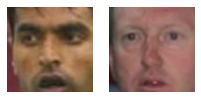

In [10]:
print(smile_ids)
print(no_smile_ids)

plot_image_samples(smile_data[0:2])
plot_image_samples(no_smile_data[0:2])

In [11]:
def dataset_loader(path, batch_size=32, shuffle=True):
    train_dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform = transforms.Compose([
                                          transforms.Resize((128, 128)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
                                      ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )

    return train_loader

lfw_people = fetch_lfw_people("./lfw/", resize=1)
data = dataset_loader("./lfw/lfw_home/lfw_funneled")

/home/janithpet/dev/LOGML2021-Learning-Latent-Geometries/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass data_home=./lfw/ as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


# Extra

In [12]:
from stochman import utilities, manifold, geodesic

model = model.cpu()

class Geodesic(manifold.EmbeddedManifold):
    def __init__(self, decoder, **kwargs):
        super(Geodesic).__init__(**kwargs)
        self.decoder = decoder

    def embed(self, points, jacobian=False):
         return  torch.cat([torch.reshape(self.decoder(points[idx]), (points.shape[0], -1)).unsqueeze(0) for idx in range(points.shape[0])], 0)
        
        
class Straightline:
    def __init__(self, p0, p1):
        self.start = p0
        self.end = p1
        
    def forward(self, t):
        t = torch.linspace(0, 1, t.shape[-1]).reshape(1, -1, 1).repeat(1, 1, p0.shape[0])
        direction_vector = (self.end - self.start)
        points = direction_vector*t
        points += self.start
    
        return points

In [13]:
geom = Geodesic(model.decoder)

X = next(iter(data))[0].cpu()
mu, log_var = model.encoder(X)
z  = torch.normal(mu, torch.exp(0.5*log_var)).cpu()

In [73]:
p0 = z[:1]
p1 = z[10:11]

curve, success = geom.connecting_geodesic(p0, p1)

straight_curve = Straightline(p0, p1)

In [175]:
def generate_points_along_curve(curve, n=11):
    t = torch.linspace(0, 1, n).reshape(1, -1)
    
    curve_points = curve.forward(t)
    
    return curve_points
    
curve_points = generate_points_along_curve(curve)
linear_points = generate_points_along_curve(straight_curve)

In [172]:
# def generate_points_along_line(p0, p1, n=11):
#     t = torch.linspace(0, 1, n).reshape(1, -1, 1).repeat(1, 1, p0.shape[0])
#     direction_vector = (p1 - p0)
#     points = direction_vector*t
#     points += p0
    
#     return points

# linear_points = generate_points_along_line(p0, p1)
print(linear_points.shape)
all_points = torch.cat((curve_points, linear_points), axis=0)

torch.Size([1, 11, 64])


In [176]:
# Plotting Images along each geodesic. [Left to Right]

def plot_along_curve(curve_points):
    B, N, L = curve_points.shape
    print(f"({B}, {N}, {L})")
    
    imgs = [model.decoder(curve_points[geod_idx]) for geod_idx in range(B)]
    print(imgs[0].shape)
    fig, ax = plt.subplots(B, N, figsize=(24, 12))
    for j in range(B):
        for i in range(N):        
            ax[j, i].imshow(imgs[j][i].transpose(0, 2).transpose(0, 1).detach().numpy())
            ax[j, i].axis('off')
    plt.show()

(2, 11, 64)
torch.Size([11, 3, 128, 128])


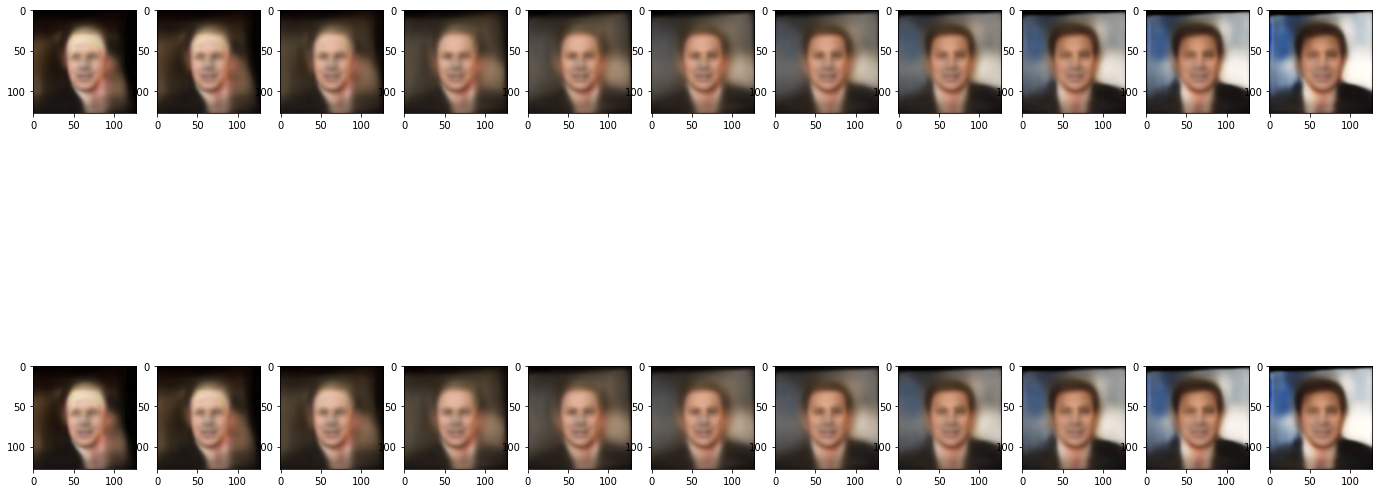

In [177]:
plot_along_curve(all_points)